# Stock Price Prediction using PySpark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=f639a89b128304e39b1226e6073110d0bb11fdf05fdade47542920eaf9f4f1f5
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
# Import necessary libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, FloatType, DateType
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName('StockPricePrediction').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/31 22:11:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data Acquisition and Preprocessing

In [3]:
# Data Selection & Acquisition
API_KEY = '61R16Q7BO31F1QAF'
symbol = 'AAPL'
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&datatype=csv'
response = requests.get(url)
with open('stock_data.csv', 'w') as file:
    file.write(response.text)

In [4]:
# Define schema
schema = StructType([
    StructField("timestamp", DateType(), True),
    StructField("open", FloatType(), True),
    StructField("high", FloatType(), True),
    StructField("low", FloatType(), True),
    StructField("close", FloatType(), True),
    StructField("volume", FloatType(), True)
])

In [5]:
# Load data
df = spark.read.csv('stock_data.csv', header=True, schema=schema)

# Verify the schema and show a sample of the data
df.printSchema()
df.show(5)

root
 |-- timestamp: date (nullable = true)
 |-- open: float (nullable = true)
 |-- high: float (nullable = true)
 |-- low: float (nullable = true)
 |-- close: float (nullable = true)
 |-- volume: float (nullable = true)



+----------+------+-------+-------+------+-----------+
| timestamp|  open|   high|    low| close|     volume|
+----------+------+-------+-------+------+-----------+
|2024-07-31|221.56| 223.82|220.638|222.08| 4.989616E7|
|2024-07-30|219.19|220.325| 216.12| 218.8| 4.164384E7|
|2024-07-29|216.96|  219.3| 215.75|218.24|3.6311776E7|
|2024-07-26| 218.7| 219.49| 216.01|217.96|4.1601344E7|
|2024-07-25|218.93| 220.85| 214.62|217.49|  5.13912E7|
+----------+------+-------+-------+------+-----------+
only showing top 5 rows



## Data Visualization

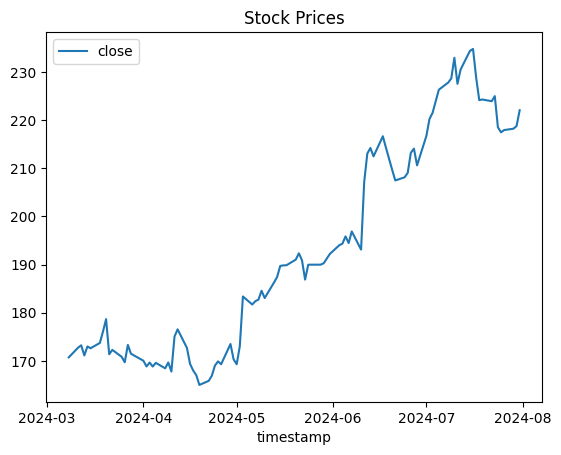

In [6]:
# Plot data
pandas_df = df.toPandas()
pandas_df.plot(x='timestamp', y='close', title='Stock Prices')
plt.show()

## Data Preprocessing

In [7]:
# Data Preprocessing
df = df.dropna().dropDuplicates()
print(f"Rows: {df.count()}, Columns: {len(df.columns)}")
df.describe().show()

# Compute the mean of the 'close' column
mean_close = df.select(mean(col('close'))).collect()[0][0]

# Encode Categorical Variables (add a dummy categorical column for demonstration)
df = df.withColumn('category', (col('close') > mean_close).cast('string'))

# Encode Categorical Variables
indexer = StringIndexer(inputCol='category', outputCol='categoryIndex')
df = indexer.fit(df).transform(df)

encoder = OneHotEncoder(inputCol='categoryIndex', outputCol='categoryVec')
df = encoder.fit(df).transform(df)

Rows: 100, Columns: 6


24/07/31 22:11:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------------+--------------------+
|summary|             open|              high|               low|             close|              volume|
+-------+-----------------+------------------+------------------+------------------+--------------------+
|  count|              100|               100|               100|               100|                 100|
|   mean|192.7828388977051| 194.7385723876953| 191.0351119995117|192.80689987182618|        6.49424034E7|
| stddev|21.93964535650485|22.242698529964077|21.356980257453763|21.888985793136083|3.2291602150745586E7|
|    min|           165.35|             166.4|           164.075|             165.0|         3.4648548E7|
|    max|           236.48|            237.23|            233.09|            234.82|         2.4642136E8|
+-------+-----------------+------------------+------------------+------------------+--------------------+



## Feature Engineering and Scaling

In [8]:
# Data Transformation
assembler = VectorAssembler(inputCols=['open', 'high', 'low', 'volume', 'categoryVec'], outputCol='features')
df = assembler.transform(df)

scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
df = scaler.fit(df).transform(df)


## Logistic Regression

In [9]:
# Logistic Regression (Binary Classification)
df = df.withColumn('label', (col('close') > mean_close).cast('integer'))

lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='label')
lr_model = lr.fit(df)

# Logistic Regression Evaluation
lr_predictions = lr_model.transform(df)
lr_evaluator = BinaryClassificationEvaluator(labelCol='label')
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Model Accuracy: {lr_accuracy}")

24/07/31 22:11:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Logistic Regression Model Accuracy: 1.0


## Linear Regression

In [10]:
# Linear Regression (Continuous Prediction)
lr = LinearRegression(featuresCol='scaledFeatures', labelCol='close')
linear_model = lr.fit(df)

# Linear Regression Evaluation
linear_predictions = linear_model.transform(df)
linear_evaluator = RegressionEvaluator(labelCol='close', metricName='rmse')
linear_rmse = linear_evaluator.evaluate(linear_predictions)
print(f"Linear Regression Model RMSE: {linear_rmse}")

24/07/31 22:11:29 WARN Instrumentation: [dd9e82bd] regParam is zero, which might cause numerical instability and overfitting.
24/07/31 22:11:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Linear Regression Model RMSE: 1.0075373321690904


## Visualization of Predictions

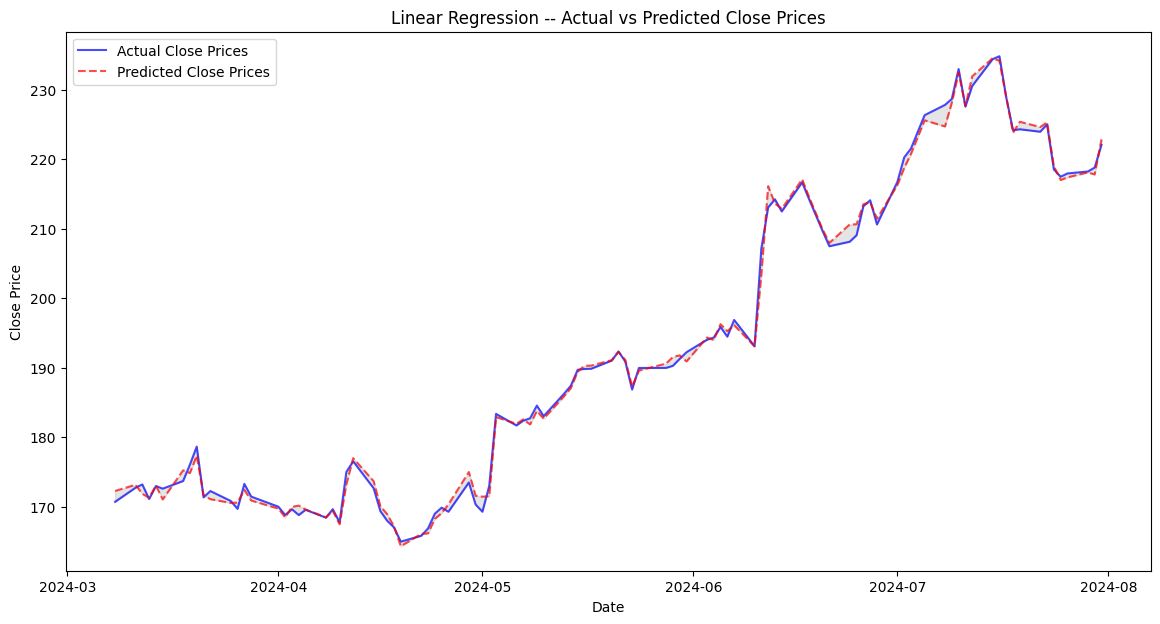

In [11]:
# Convert predictions to Pandas DataFrame for visualization
pred_df = linear_predictions.select("timestamp", "close", "prediction").toPandas()

# Sort by timestamp to ensure the lines are drawn correctly
pred_df = pred_df.sort_values('timestamp')

# Plot actual vs predicted closing prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)
plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Linear Regression -- Actual vs Predicted Close Prices')
plt.legend()
plt.show()

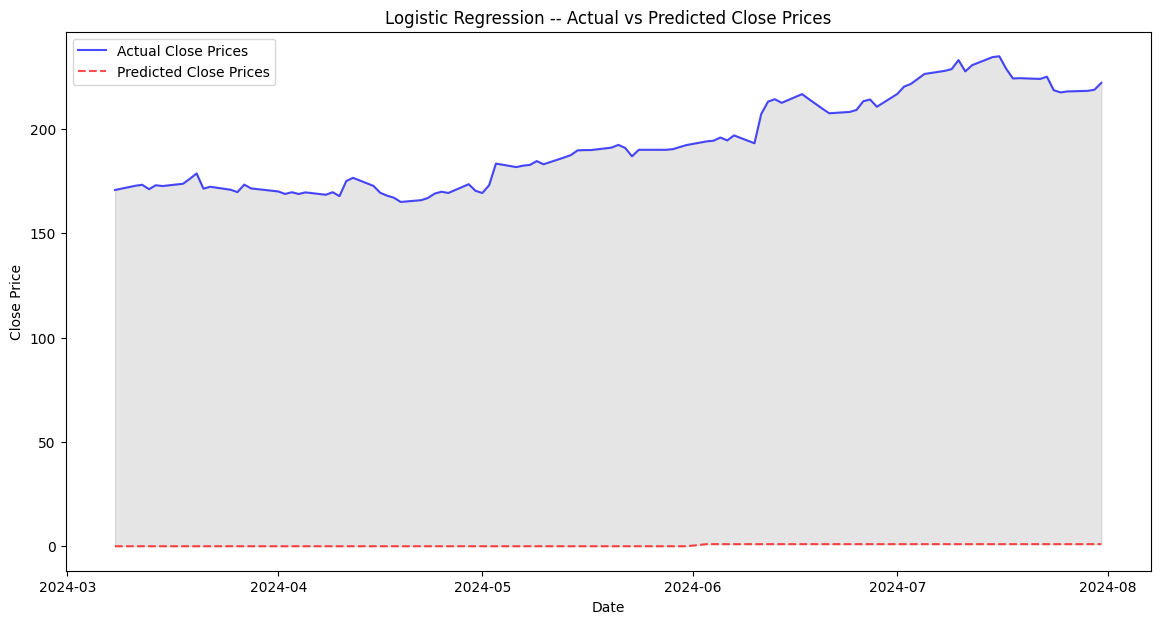

In [12]:
# Convert predictions to Pandas DataFrame for visualization
pred_df = lr_predictions.select("timestamp", "close", "prediction").toPandas()

# Sort by timestamp to ensure the lines are drawn correctly
pred_df = pred_df.sort_values('timestamp')

# Plot actual vs predicted closing prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['timestamp'], pred_df['close'], label='Actual Close Prices', color='blue', alpha=0.7)
plt.plot(pred_df['timestamp'], pred_df['prediction'], label='Predicted Close Prices', color='red', linestyle='--', alpha=0.7)
plt.fill_between(pred_df['timestamp'], pred_df['close'], pred_df['prediction'], color='gray', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Logistic Regression -- Actual vs Predicted Close Prices')
plt.legend()
plt.show()

## Results

As we observed, based on the visualizations. we can conclude Linear Regression is the best fit for prediction. 